In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as time

import importlib
import util
import data_preparation

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# CSI5155 Fall 2020 Final Project
# Name: Jing Dai
# Student Number: 300169665

In [72]:
# https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
importlib.reload(util)
importlib.reload(data_preparation)
%run util.py

In [3]:
def load_data(target_index = 49):
    data_frame = pd.read_csv("./dataset/diabetic_data.csv", delimiter=",", header=0, na_values="?")

    X_df, y_df = pd.concat([data_frame.iloc[:, 0:target_index], data_frame.iloc[:, target_index+1:50]], axis=1), data_frame.iloc[:, target_index]

    pd.set_option("display.max_columns", None)

    return pd.DataFrame(X_df), pd.DataFrame(y_df)

# Supervised Learning

In [78]:
def supervised_learning(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

    random_forest_classifier = OneVsRestClassifier(RandomForestClassifier(criterion="gini", max_depth=30, random_state=42, n_jobs=-1))
    random_forests_scores = util.model_scores(np.array(cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring="accuracy")))
    random_forest_classifier.fit(X_train, y_train)
    rf_y_pred = random_forest_classifier.predict(X_test)
    rf_y_score = random_forest_classifier.predict_proba(X_test)
    util.plot_roc_curve(y_test, rf_y_score, "Random Forest")

    decision_tree_classifier = OneVsRestClassifier(DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42))
    decision_tree_scores = util.model_scores(np.array(cross_val_score(decision_tree_classifier, X_train, y_train, cv=5, scoring="accuracy")))
    decision_tree_classifier.fit(X_train, y_train)
    dt_y_pred = decision_tree_classifier.predict(X_test)
    dt_y_score = decision_tree_classifier.predict_proba(X_test)
    util.plot_roc_curve(y_test, dt_y_score, "Decision Tree")

    naive_bayes_classifier = OneVsRestClassifier(GaussianNB())
    naive_bayes_scores = util.model_scores(np.array(cross_val_score(naive_bayes_classifier, X_train, y_train, cv=5, scoring="accuracy")))
    naive_bayes_classifier.fit(X_train, y_train)
    nb_y_pred = naive_bayes_classifier.predict(X_test)
    nb_y_score = naive_bayes_classifier.predict_proba(X_test)
    util.plot_roc_curve(y_test, nb_y_score, "Naive Bayes")

    knn_classifier = OneVsRestClassifier(KNeighborsClassifier(n_jobs=-1))
    knn_scores = util.model_scores(np.array(cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring="accuracy")))
    knn_classifier.fit(X_train, y_train)
    knn_y_pred = knn_classifier.predict(X_test)
    knn_y_score = knn_classifier.predict_proba(X_test)
    util.plot_roc_curve(y_test, knn_y_score, "k-NN")

    gradient_boosting_classifier = OneVsRestClassifier(GradientBoostingClassifier())
    gradient_boosting_scores = util.model_scores(np.array(cross_val_score(gradient_boosting_classifier, X_train, y_train, cv=5, scoring="accuracy")))
    gradient_boosting_classifier.fit(X_train, y_train)
    gb_y_pred = gradient_boosting_classifier.predict(X_test)
    gb_y_score = gradient_boosting_classifier.decision_function(X_test)
    util.plot_roc_curve(y_test, gb_y_score, "Gradient Boosting")

    print("accuracy for random forest: {:0.2f}".format(accuracy_score(y_test, rf_y_pred)))
    print("accuracy for decision tree: {:0.2f}".format(accuracy_score(y_test, dt_y_pred)))
    print("accuracy for naive bayes: {:0.2f}".format(accuracy_score(y_test, nb_y_pred)))
    print("accuracy for k-NN: {:0.2f}".format(accuracy_score(y_test, knn_y_pred)))
    print("accuracy for gradient boosting: {:0.2f}".format(accuracy_score(y_test, gb_y_pred)))
    print("\n")

    print("f1 score for random forest: {:0.2f}".format(f1_score(y_test, rf_y_pred, average="macro")))
    print("f1 score for decision tree: {:0.2f}".format(f1_score(y_test, dt_y_pred, average="macro")))
    print("f1 score for naive bayes: {:0.2f}".format(f1_score(y_test, nb_y_pred, average="macro")))
    print("f1 score for k-NN: {:0.2f}".format(f1_score(y_test, knn_y_pred, average="macro")))
    print("f1 score for gradient boosting: {:0.2f}".format(f1_score(y_test, gb_y_pred, average="macro")))
    print("\n")

    all_scores = (random_forests_scores, decision_tree_scores, naive_bayes_scores, knn_scores, gradient_boosting_scores)
    util.display_cv_f1_scores(all_scores, ["Random Forest", "Decision Tree", "Naive Bayes", "k-NN", "Gradient Boosting"])
    util.display_statistical_differences(all_scores, ["RF", "DT", "NB", "KNN", "GB"])

### Supervised Learning - Admissions

In [57]:
X_raw_1, y_raw_1 = load_data()

X_1, y_1 = data_preparation.data_cleaning(X_raw_1, y_raw_1)

unique_counts = pd.DataFrame.from_records([(col, X_1[col].nunique(), X_1[col].dtypes) for col in X_1.columns],
                                              columns=['Column Name', 'Num of Uniques', "Type"]).sort_values(by=['Num of Uniques'])
display(unique_counts)

y_1.replace({"<30": 1, ">30": 2, "NO": 3}, inplace=True)
X_1, y_1 = data_preparation.feature_encoding(X_1, y_1)
print("X_train before feature selection: ", X_1.shape)
X_1, y_1 = data_preparation.feature_selection(X_1, y_1)
X_1, y_1 = data_preparation.data_balancing(X_1, y_1)
print("X_train after feature selection: ", X_1.shape)

/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,features contain single value
0,examide
1,citoglipton


No duplicated rows
X_train before feature selection:  (101766, 94)
after oversampling: 
 readmitted
3             0.333333
2             0.333333
1             0.333333
dtype: float64
X_train after feature selection:  (164592, 94)


,features contain missing values,count,percentage
0,race,2273,2.23%
1,weight,98569,96.86%
2,payer_code,40256,39.56%
3,medical_specialty,49949,49.08%
4,diag_1,21,0.02%
5,diag_2,358,0.35%
6,diag_3,1423,1.40%


,Column Name,Num of Uniques,Type
45,diabetesMed,2,object
28,acetohexamide,2,object
31,tolbutamide,2,object
36,troglitazone,2,object
40,glipizide-metformin,2,object
44,change,2,object
42,metformin-rosiglitazone,2,object
43,metformin-pioglitazone,2,object
41,glimepiride-pioglitazone,2,object
37,tolazamide,3,object


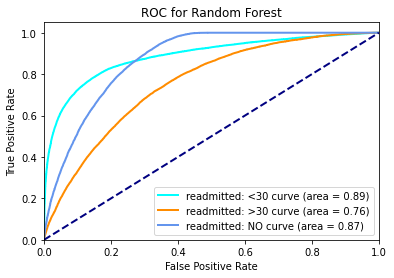

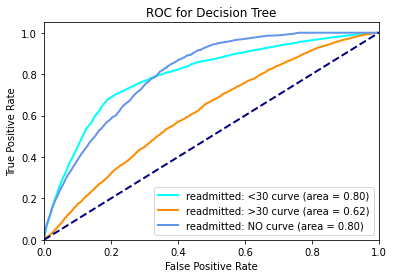

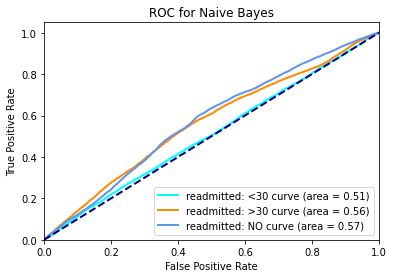

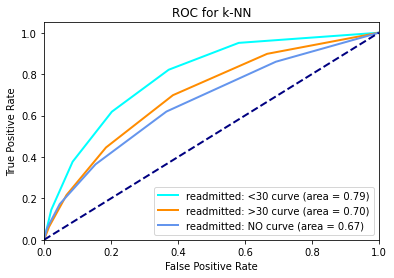

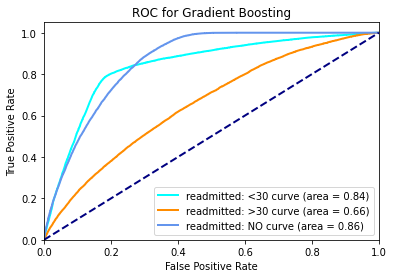

accuracy for random forest: 0.66
accuracy for decision tree: 0.56
accuracy for naive bayes: 0.38
accuracy for k-NN: 0.54
accuracy for gradient boosting: 0.63


f1 score for random forest: 0.64
f1 score for decision tree: 0.55
f1 score for naive bayes: 0.34
f1 score for k-NN: 0.54
f1 score for gradient boosting: 0.60




,Random Forest,Decision Tree,Naive Bayes,k-NN,Gradient Boosting
1,0.655513,0.562069,0.386970,0.517682,0.629081
2,0.654591,0.555112,0.383813,0.516436,0.625391
3,0.655271,0.555339,0.384901,0.524734,0.624802
4,0.652959,0.561097,0.380186,0.521832,0.624620
5,0.652596,0.558286,0.382090,0.522603,0.627703
avg,0.654186,0.558381,0.383592,0.520657,0.626319
stdev,0.001195,0.002861,0.002325,0.003113,0.001766


,RF-DT,RF-NB,RF-KNN,RF-GB,DT-NB,DT-KNN,DT-GB,NB-KNN,NB-GB,KNN-GB
1,0.093444,0.268544,0.137831,0.026433,0.175100,0.044387,-0.067011,-0.130713,-0.242111,-0.111398
2,0.099479,0.270778,0.138155,0.029200,0.171299,0.038676,-0.070279,-0.132623,-0.241578,-0.108955
3,0.099932,0.270370,0.130537,0.030469,0.170438,0.030605,-0.069463,-0.139832,-0.239900,-0.100068
4,0.091861,0.272773,0.131127,0.028338,0.180911,0.039265,-0.063523,-0.141646,-0.244434,-0.102788
5,0.094310,0.270506,0.129993,0.024892,0.176196,0.035684,-0.069417,-0.140512,-0.245613,-0.105101
avg,0.095805,0.270594,0.133529,0.027866,0.174789,0.037723,-0.067939,-0.137065,-0.242727,-0.105662
stdev,0.003283,0.001345,0.003664,0.001984,0.003760,0.004528,0.002463,0.004486,0.002046,0.004089
p-value,0.001090,0.000990,0.001064,0.001174,0.000953,0.001236,0.001084,0.000947,0.000979,0.001066


In [75]:
# Supervised Learning - Admissions

supervised_learning(X_1, y_1)


### Supervised Learning - Age ranges

In [127]:
X_raw_2, y_raw_2 = load_data(target_index=4)
X_2, y_2 = data_preparation.data_cleaning(X_raw_2, y_raw_2)

unique_counts = pd.DataFrame.from_records([(col, X_2[col].nunique(), X_2[col].dtypes) for col in X_2.columns],
                                              columns=['Column Name', 'Num of Uniques', "Type"]).sort_values(by=['Num of Uniques'])
display(unique_counts)

y_2 = y_2.replace({
    "[0-10)": "young",
    "[10-20)": "young",
    "[20-30)": "young",
    "[30-40)": "mid-age",
    "[40-50)": "mid-age",
    "[50-60)": "mid-age",
    "[60-70)": "old",
    "[70-80)": "old",
    "[80-90)": "old",
    "[90-100)": "old"
})
y_2 = y_2.replace({
    "young": 1,
    "mid-age": 2,
    "old": 3,
})

X_2, y_2 = data_preparation.feature_encoding(X_2, y_2, age_as_target=True)
print("X_train before feature selection: ", X_2.shape)
X_2, y_2 = data_preparation.feature_selection(X_2, y_2)
X_2, y_2 = data_preparation.data_balancing(X_2, y_2)
print("X_train after feature selection: ", X_2.shape)

/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,features contain single value
0,examide
1,citoglipton


No duplicated rows
X_train before feature selection:  (101766, 96)
after oversampling: 
 age
3      0.333333
2      0.333333
1      0.333333
dtype: float64
X_train after feature selection:  (205623, 96)


,features contain missing values,count,percentage
0,race,2273,2.23%
1,weight,98569,96.86%
2,payer_code,40256,39.56%
3,medical_specialty,49949,49.08%
4,diag_1,21,0.02%
5,diag_2,358,0.35%
6,diag_3,1423,1.40%


,Column Name,Num of Uniques,Type
44,diabetesMed,2,object
43,change,2,object
42,metformin-pioglitazone,2,object
27,acetohexamide,2,object
41,metformin-rosiglitazone,2,object
40,glimepiride-pioglitazone,2,object
39,glipizide-metformin,2,object
30,tolbutamide,2,object
35,troglitazone,2,object
45,readmitted,3,object


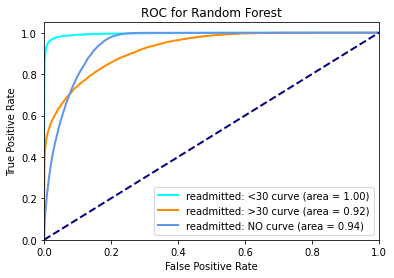

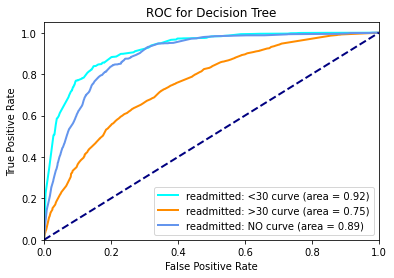

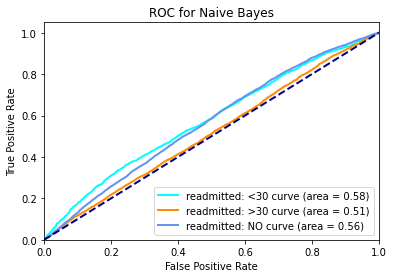

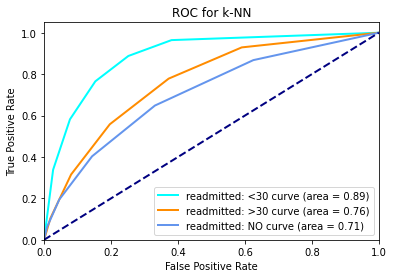

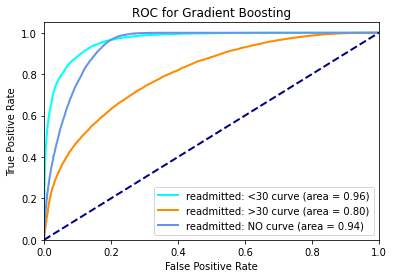

accuracy for random forest: 0.85
accuracy for decision tree: 0.70
accuracy for naive bayes: 0.37
accuracy for k-NN: 0.61
accuracy for gradient boosting: 0.77


f1 score for random forest: 0.85
f1 score for decision tree: 0.69
f1 score for naive bayes: 0.30
f1 score for k-NN: 0.61
f1 score for gradient boosting: 0.76




,Random Forest,Decision Tree,Naive Bayes,k-NN,Gradient Boosting
1,0.842890,0.696015,0.371380,0.587719,0.767221
2,0.844451,0.697213,0.373013,0.591420,0.770959
3,0.846950,0.700432,0.371212,0.595180,0.770152
4,0.843429,0.694080,0.373172,0.593765,0.766632
5,0.840961,0.693500,0.369034,0.593692,0.766995
avg,0.843736,0.696248,0.371562,0.592355,0.768392
stdev,0.001967,0.002480,0.001499,0.002613,0.001795


,RF-DT,RF-NB,RF-KNN,RF-GB,DT-NB,DT-KNN,DT-GB,NB-KNN,NB-GB,KNN-GB
1,0.146875,0.471510,0.255172,0.075670,0.324635,0.108296,-0.071206,-0.216339,-0.395841,-0.179502
2,0.147238,0.471438,0.253030,0.073492,0.324200,0.105792,-0.073746,-0.218407,-0.397946,-0.179538
3,0.146518,0.475738,0.251769,0.076797,0.329220,0.105252,-0.069720,-0.223968,-0.398940,-0.174972
4,0.149349,0.470257,0.249664,0.076797,0.320909,0.100316,-0.072551,-0.220593,-0.393460,-0.172867
5,0.147461,0.471927,0.247269,0.073967,0.324466,0.099808,-0.073495,-0.224658,-0.397960,-0.173302
avg,0.147488,0.472174,0.251381,0.075345,0.324686,0.103893,-0.072144,-0.220793,-0.396829,-0.176036
stdev,0.000984,0.001866,0.002724,0.001390,0.002650,0.003296,0.001504,0.003181,0.001965,0.002930
p-value,0.000986,0.000959,0.000982,0.000956,0.000948,0.000987,0.001029,0.000938,0.000961,0.000996


In [79]:
# Supervised Learning - Admissions

supervised_learning(X_2, y_2)

# Semi-supervised Learning

In [122]:
def semi_supervised_learning_label_propagation(X, y):
    print("Label Propagation")
    print("Runtime - start time: ", time.time())
    scores = list()
    for percentage in [0, 0.1, 0.2, 0.5, 0.9, 0.95]:
        y_true_unlabelled = y
        if percentage != 0:
            y_true_unlabelled = util.semi_supervised_learning_splits(X, y, percentage)

        # Label Propagation
        # Label Propagation - predict labels for unlabelled data.
        label_propagation = LabelPropagation(kernel="knn", max_iter=100)
        label_propagation.fit(X, y_true_unlabelled)
        y_pred_unlabelled = label_propagation.predict(X)
        print("LabelPropagation - accuracy for {}% unlabelled re-admissions: {:0.2f}".format(percentage, accuracy_score(y_true_unlabelled, y_pred_unlabelled)))

        # Label Propagation - Re-trained the model with pseudo and labelled datasets together
        X_train_propagation, X_test_propagation, y_train_propagation, y_test_propagation = train_test_split(X, y_pred_unlabelled, test_size=0.33, random_state=42, stratify=y_pred_unlabelled)
        random_forest_classifier = OneVsRestClassifier(RandomForestClassifier(criterion="gini", max_depth=30, random_state=42, n_jobs=-1))
        random_forest_classifier.fit(X_train_propagation, y_train_propagation)
        y_pred_propagation = random_forest_classifier.predict(X_test_propagation)
        y_score_propagation = random_forest_classifier.predict_proba(X_test_propagation)
        print("LabelPropagation re-trained Random Forest - accuracy for {}% unlabelled re-admissions: {:0.2f}".format(percentage, accuracy_score(y_test_propagation, y_pred_propagation)))
        print("LabelPropagation re-trained Random Forest - f-1 score for {}% unlabelled re-admissions: {:0.2f}\n".format(percentage, f1_score(y_test_propagation, y_pred_propagation, average="macro")))
        util.plot_roc_curve(y_test_propagation, y_score_propagation, "Random Forest")

        if percentage != 0:
            scores.append(accuracy_score(y_test_propagation, y_pred_propagation))

    print("Runtime - end time: ", time.time())
    return scores

def semi_supervised_learning_label_spreading(X, y):
    print("\nLabel Spreading")
    print("Runtime - start time: ", time.time())
    scores = list()
    for percentage in [0, 0.1, 0.2, 0.5, 0.9, 0.95]:
        y_true_unlabelled = y
        if percentage != 0:
            y_true_unlabelled = util.semi_supervised_learning_splits(X, y, percentage)

        # Label Spreading
        # Label Spreading - predict labels for unlabelled data.
        label_spreading = LabelSpreading(kernel="knn", max_iter=100)
        label_spreading.fit(X, y_true_unlabelled)
        y_pred_unlabelled = label_spreading.predict(X)
        print("LabelSpreading - accuracy for {}% unlabelled re-admissions: {:0.2f}".format(percentage, accuracy_score(y_true_unlabelled, y_pred_unlabelled)))

        # Label Propagation - Re-trained the model with pseudo and labelled datasets together
        X_train_spreading, X_test_spreading, y_train_spreading, y_test_spreading = train_test_split(X, y_pred_unlabelled, test_size=0.33, random_state=42, stratify=y_pred_unlabelled)
        random_forest_classifier = OneVsRestClassifier(RandomForestClassifier(criterion="gini", max_depth=30, random_state=42, n_jobs=-1))
        random_forest_classifier.fit(X_train_spreading, y_train_spreading)
        y_pred_spreading = random_forest_classifier.predict(X_test_spreading)
        y_score_spreading = random_forest_classifier.predict_proba(X_test_spreading)
        print("LabelSpreading re-trained Random Forest - accuracy for {}% unlabelled re-admissions: {:0.2f}".format(percentage, accuracy_score(y_test_spreading, y_pred_spreading)))
        print("LabelPropagation re-trained Random Forest - f-1 score for {}% unlabelled re-admissions: {:0.2f}\n".format(percentage, f1_score(y_test_spreading, y_pred_spreading, average="macro")))
        util.plot_roc_curve(y_test_spreading, y_score_spreading, "Random Forest")

        if percentage != 0:
            scores.append(accuracy_score(y_test_spreading, y_pred_spreading))

    print("Runtime - end time: ", time.time())
    return scores

def semi_supervised_learning_self_training(X, y):
    print("\nSelf Training")
    print("Runtime - start time: ", time.time())
    scores = list()
    for percentage in [0.1, 0.2, 0.5, 0.9, 0.95]:
        X_labelled, y_labelled, X_unlabelled = util.self_training_splits(X, y, percentage)
        X_labelled_train, X_labelled_test, y_labelled_train, y_labelled_test = train_test_split(X_labelled, y_labelled, test_size=0.33, random_state=42, stratify=y_labelled)
        X_labelled_train = pd.DataFrame(X_labelled_train)
        y_labelled_train = pd.DataFrame(y_labelled_train)
        X_unlabelled = pd.DataFrame(X_unlabelled)

        pseudo_labels = list()
        test_f1_scores = list()
        concat_result = pd.DataFrame([1])
        iterations = 0
        while len(concat_result) > 0:
            print("\nIteration: {}".format(iterations))
            random_forest_classifier = OneVsRestClassifier(RandomForestClassifier(criterion="gini", max_depth=30, random_state=42, n_jobs=-1))
            random_forest_classifier.fit(X_labelled_train, y_labelled_train)

            y_labelled_pred = random_forest_classifier.predict(X_labelled_test)
            test_f1_score = f1_score(y_labelled_test, y_labelled_pred, average="macro")
            test_f1_scores.append(test_f1_score)
            print("f1 score: {}".format(test_f1_score))

            y_pred = random_forest_classifier.predict(X_unlabelled)
            y_pred_proba = random_forest_classifier.predict_proba(X_unlabelled)
            y_pred_proba_0, y_pred_proba_1 = y_pred_proba[:, 0], y_pred_proba[:, 1]

            y_pred_proba_df = pd.DataFrame()
            y_pred_proba_df["y_pred"] = y_pred
            y_pred_proba_df["y_pred_proba_0"] = y_pred_proba_0
            y_pred_proba_df["y_pred_proba_1"] = y_pred_proba_1
            y_pred_proba_df.index = X_unlabelled.index

            concat_result = pd.concat([y_pred_proba_df.loc[y_pred_proba_df["y_pred_proba_0"] > 0.97],
                                       y_pred_proba_df.loc[y_pred_proba_df["y_pred_proba_1"] > 0.97]
                                      ], axis=0)
            print("{}% unlabelled re-admissions: {} high-probability predictions are added to labelled data".format(percentage, len(concat_result)))

            pseudo_labels.append(len(concat_result))

            X_labelled_train = pd.concat([X_labelled_train, X_unlabelled.loc[concat_result.index]], axis=0)
            y_labelled_train = pd.concat([y_labelled_train, concat_result["y_pred"]])

            X_unlabelled.drop(index=concat_result.index, inplace=True)
            print("{}% unlabelled re-admissions: {} unlabelled data left".format(percentage, len(X_unlabelled)))

            iterations = iterations + 1

        random_forest_classifier = OneVsRestClassifier(RandomForestClassifier(criterion="gini", max_depth=30, random_state=42, n_jobs=-1))
        random_forest_classifier.fit(X_labelled_train, y_labelled_train)
        y_pred = random_forest_classifier.predict(X_labelled_test)
        y_score = random_forest_classifier.predict_proba(X_labelled_test)
        util.plot_roc_curve(y_labelled_test, y_score, "Random Forest")

        scores.append(accuracy_score(y_labelled_test, y_pred))

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
        ax1.plot(range(iterations), test_f1_scores)
        ax1.set_ylabel('f1 score for percentage: {}%'.format(percentage))
        ax2.bar(x=range(iterations), height=pseudo_labels)
        ax2.set_ylabel('Number of Pseudo-Labels Created')
        ax2.set_xlabel('Number of Iterations')
        plt.show()

    print("Runtime - end time: ", time.time())
    return scores


In [49]:
X_raw_semi, y_raw_semi = load_data()
X_semi, y_semi = data_preparation.data_cleaning(X_raw_semi, y_raw_semi)
y_semi.replace({"<30": 1, ">30": 2, "NO": 3}, inplace=True)
X_semi, y_semi = data_preparation.feature_encoding(X_semi, y_semi)
X_semi, y_semi = data_preparation.feature_selection(X_semi, y_semi)
X_semi, y_semi = data_preparation.data_balancing(X_semi, y_semi)
y_semi = np.array(y_semi)

/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,features contain single value
0,examide
1,citoglipton


No duplicated rows
after oversampling: 
 readmitted
3             0.333333
2             0.333333
1             0.333333
dtype: float64


,features contain missing values,count,percentage
0,race,2273,2.23%
1,weight,98569,96.86%
2,payer_code,40256,39.56%
3,medical_specialty,49949,49.08%
4,diag_1,21,0.02%
5,diag_2,358,0.35%
6,diag_3,1423,1.40%


Label Propagation
Runtime - start time:  1608121260.8742452
LabelPropagation - accuracy for 0% unlabelled re-admissions: 0.67
LabelPropagation re-trained Random Forest - accuracy for 0% unlabelled re-admissions: 0.55
LabelPropagation re-trained Random Forest - f-1 score for 0% unlabelled re-admissions: 0.53

LabelPropagation - accuracy for 0.1% unlabelled re-admissions: 0.61
LabelPropagation re-trained Random Forest - accuracy for 0.1% unlabelled re-admissions: 0.55
LabelPropagation re-trained Random Forest - f-1 score for 0.1% unlabelled re-admissions: 0.54

LabelPropagation - accuracy for 0.2% unlabelled re-admissions: 0.55
LabelPropagation re-trained Random Forest - accuracy for 0.2% unlabelled re-admissions: 0.55
LabelPropagation re-trained Random Forest - f-1 score for 0.2% unlabelled re-admissions: 0.53

LabelPropagation - accuracy for 0.5% unlabelled re-admissions: 0.33
LabelPropagation re-trained Random Forest - accuracy for 0.5% unlabelled re-admissions: 0.54
LabelPropagation 

/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/semi_supervised/_label_propagation.py:281: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= no

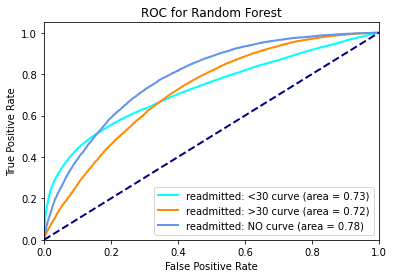

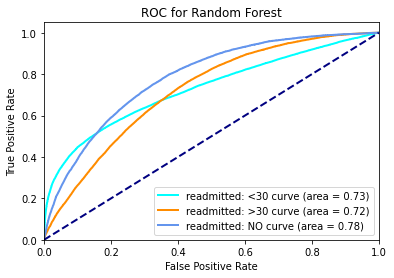

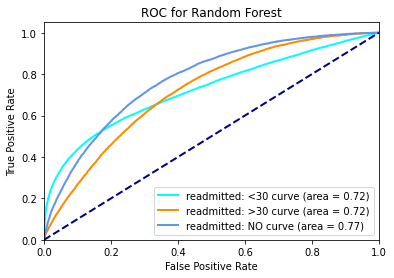

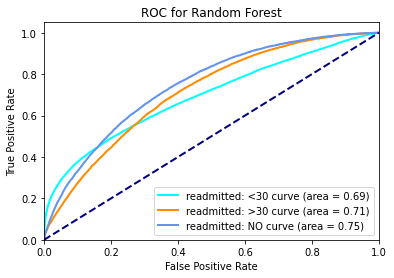

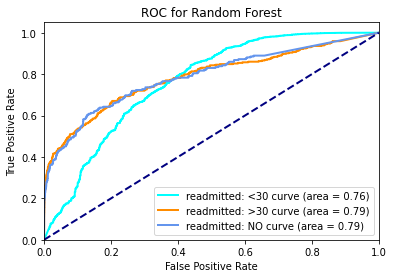

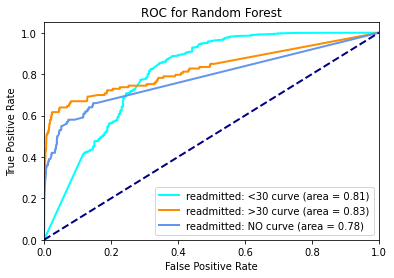

In [123]:
# Label Propagation

label_propagation_scores = semi_supervised_learning_label_propagation(X_semi, y_semi)


Label Spreading
Runtime - start time:  1608121616.753453
LabelSpreading - accuracy for 0% unlabelled re-admissions: 0.67
LabelSpreading re-trained Random Forest - accuracy for 0% unlabelled re-admissions: 0.56
LabelPropagation re-trained Random Forest - f-1 score for 0% unlabelled re-admissions: 0.55

LabelSpreading - accuracy for 0.1% unlabelled re-admissions: 0.61
LabelSpreading re-trained Random Forest - accuracy for 0.1% unlabelled re-admissions: 0.55
LabelPropagation re-trained Random Forest - f-1 score for 0.1% unlabelled re-admissions: 0.55

LabelSpreading - accuracy for 0.2% unlabelled re-admissions: 0.55
LabelSpreading re-trained Random Forest - accuracy for 0.2% unlabelled re-admissions: 0.55
LabelPropagation re-trained Random Forest - f-1 score for 0.2% unlabelled re-admissions: 0.54

LabelSpreading - accuracy for 0.5% unlabelled re-admissions: 0.36
LabelSpreading re-trained Random Forest - accuracy for 0.5% unlabelled re-admissions: 0.54
LabelPropagation re-trained Random 

/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/kobedai/MLProjects/env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

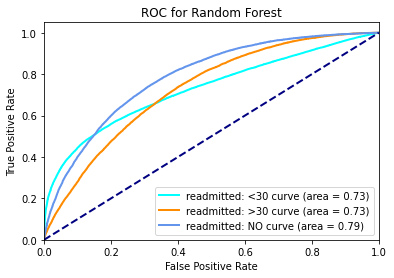

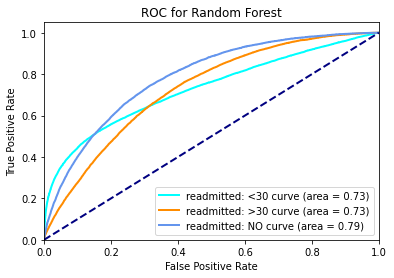

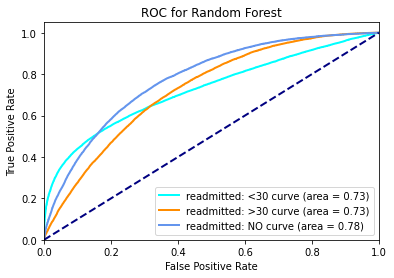

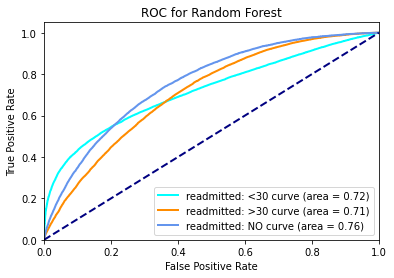

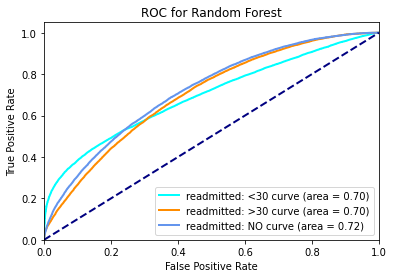

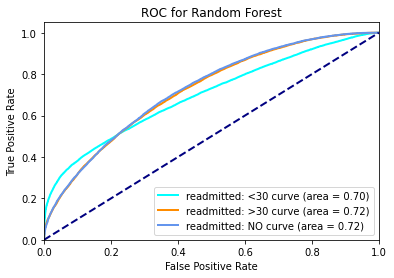

In [124]:
# Label Spreading

label_spreading_scores = semi_supervised_learning_label_spreading(X_semi, y_semi)


Self Training
Runtime - start time:  1608121952.2078788

Iteration: 0
f1 score: 0.6326301076068728
0.1% unlabelled re-admissions: 2 high-probability predictions are added to labelled data
0.1% unlabelled re-admissions: 16458 unlabelled data left

Iteration: 1
f1 score: 0.6339809446816157
0.1% unlabelled re-admissions: 1 high-probability predictions are added to labelled data
0.1% unlabelled re-admissions: 16457 unlabelled data left

Iteration: 2
f1 score: 0.633457624617797
0.1% unlabelled re-admissions: 1 high-probability predictions are added to labelled data
0.1% unlabelled re-admissions: 16456 unlabelled data left

Iteration: 3
f1 score: 0.6335782968482525
0.1% unlabelled re-admissions: 1 high-probability predictions are added to labelled data
0.1% unlabelled re-admissions: 16455 unlabelled data left

Iteration: 4
f1 score: 0.6332422003773055
0.1% unlabelled re-admissions: 1 high-probability predictions are added to labelled data
0.1% unlabelled re-admissions: 16454 unlabelled data

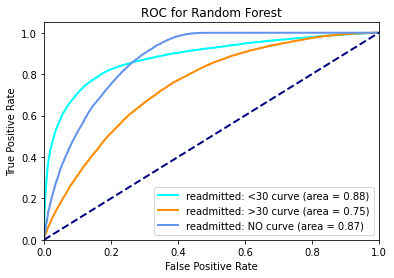

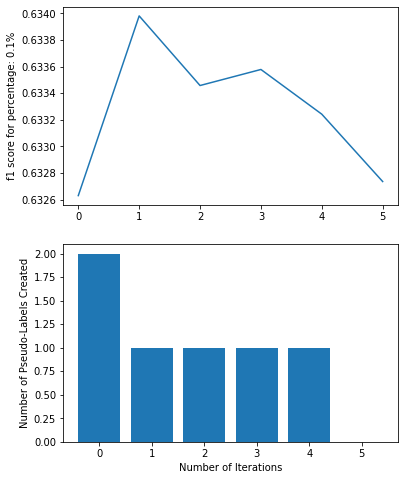

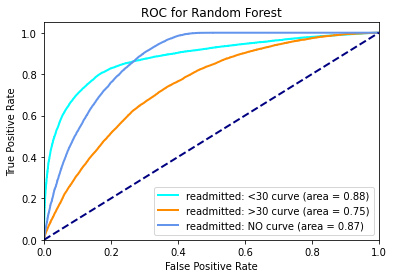

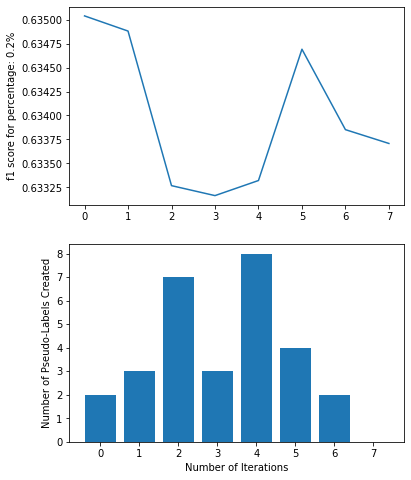

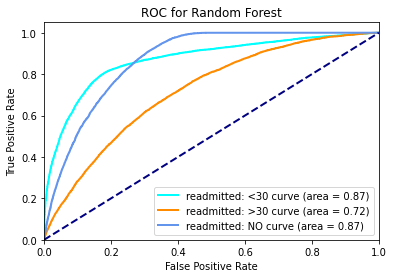

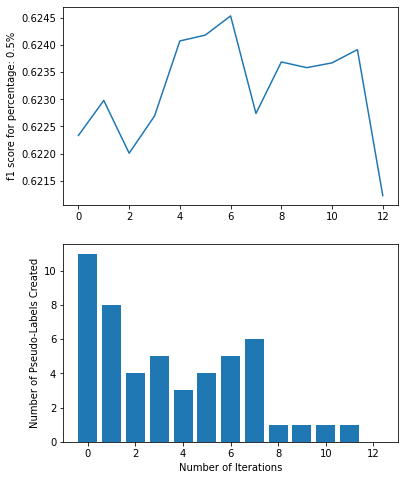

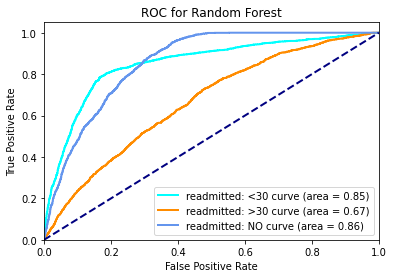

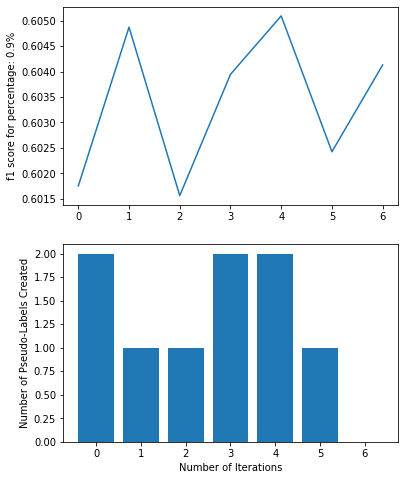

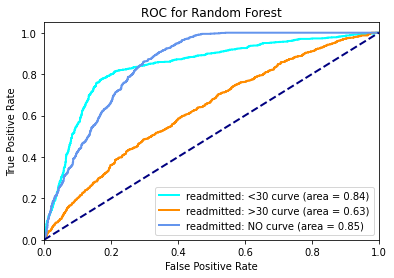

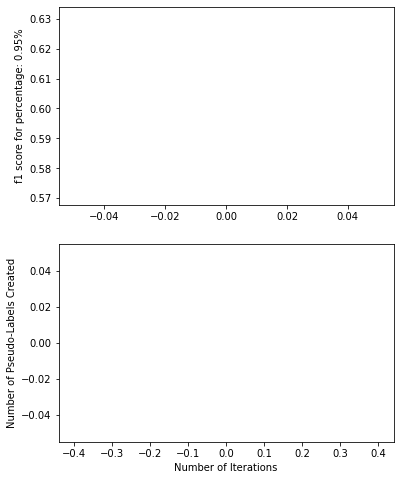

In [126]:
# Self Training

self_training_scores = semi_supervised_learning_self_training(X_semi, y_semi)

In [125]:
# util.model_scores(np.array(cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring="accuracy")))
semi_all_scores = (util.model_scores(np.array(label_propagation_scores)), util.model_scores(np.array(label_spreading_scores)), util.model_scores(np.array(self_training_scores)))
util.display_statistical_differences(semi_all_scores, ["10%", "20%", "50%", "90%", "95%"])



,10%-20%,10%-50%,20%-50%
1,-0.004400,-0.101537,-0.097137
2,-0.005247,-0.108473,-0.103226
3,0.000608,-0.103837,-0.104444
4,0.479177,0.363512,-0.115666
5,0.479122,0.378074,-0.101048
avg,0.189852,0.085548,-0.104304
stdev,0.236219,0.232958,0.006201
p-value,0.057105,0.258227,0.001241
